In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
os.listdir(train_dir)

['dogs', 'cats']

In [4]:
os.listdir(os.path.join(train_dir, 'cats'))

['cat.335.jpg',
 'cat.766.jpg',
 'cat.355.jpg',
 'cat.6.jpg',
 'cat.899.jpg',
 'cat.284.jpg',
 'cat.185.jpg',
 'cat.272.jpg',
 'cat.426.jpg',
 'cat.567.jpg',
 'cat.987.jpg',
 'cat.712.jpg',
 'cat.308.jpg',
 'cat.862.jpg',
 'cat.202.jpg',
 'cat.900.jpg',
 'cat.659.jpg',
 'cat.845.jpg',
 'cat.160.jpg',
 'cat.239.jpg',
 'cat.860.jpg',
 'cat.981.jpg',
 'cat.448.jpg',
 'cat.728.jpg',
 'cat.52.jpg',
 'cat.668.jpg',
 'cat.868.jpg',
 'cat.497.jpg',
 'cat.581.jpg',
 'cat.432.jpg',
 'cat.698.jpg',
 'cat.433.jpg',
 'cat.441.jpg',
 'cat.784.jpg',
 'cat.530.jpg',
 'cat.805.jpg',
 'cat.396.jpg',
 'cat.318.jpg',
 'cat.264.jpg',
 'cat.34.jpg',
 'cat.123.jpg',
 'cat.955.jpg',
 'cat.135.jpg',
 'cat.798.jpg',
 'cat.22.jpg',
 'cat.648.jpg',
 'cat.290.jpg',
 'cat.266.jpg',
 'cat.403.jpg',
 'cat.360.jpg',
 'cat.14.jpg',
 'cat.522.jpg',
 'cat.957.jpg',
 'cat.734.jpg',
 'cat.89.jpg',
 'cat.794.jpg',
 'cat.736.jpg',
 'cat.257.jpg',
 'cat.706.jpg',
 'cat.994.jpg',
 'cat.593.jpg',
 'cat.334.jpg',
 'cat.505.jpg',

In [5]:
from PIL import Image

img = Image.open(os.path.join(train_dir, 'cats', 'cat.1.jpg'))
img.size

(300, 280)

In [6]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


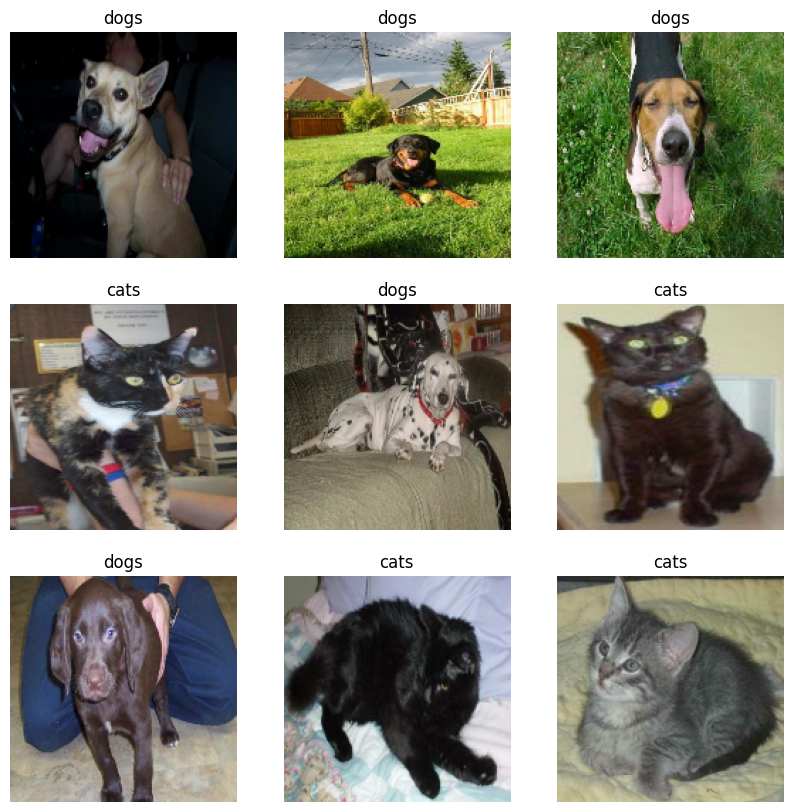

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [26]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 98ms/step - loss: 0.7934 - accuracy: 0.5149


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.51


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 12s 140ms/step - loss: 0.7045 - accuracy: 0.5880 - val_loss: 0.5353 - val_accuracy: 0.7438
Epoch 2/10
63/63 [==============================] - 9s 138ms/step - loss: 0.5281 - accuracy: 0.7425 - val_loss: 0.3948 - val_accuracy: 0.8700
Epoch 3/10
63/63 [==============================] - 8s 132ms/step - loss: 0.4308 - accuracy: 0.8075 - val_loss: 0.3130 - val_accuracy: 0.9072
Epoch 4/10
63/63 [==============================] - 8s 130ms/step - loss: 0.3553 - accuracy: 0.8705 - val_loss: 0.2526 - val_accuracy: 0.9295
Epoch 5/10
63/63 [==============================] - 8s 133ms/step - loss: 0.3087 - accuracy: 0.8875 - val_loss: 0.2137 - val_accuracy: 0.9381
Epoch 6/10
63/63 [==============================] - 8s 135ms/step - loss: 0.3001 - accuracy: 0.8805 - val_loss: 0.1960 - val_accuracy: 0.9443
Epoch 7/10
63/63 [==============================] - 8s 131ms/step - loss: 0.2670 - accuracy: 0.9000 - val_loss: 0.1734 - val_accuracy: 0.9505
Epoch

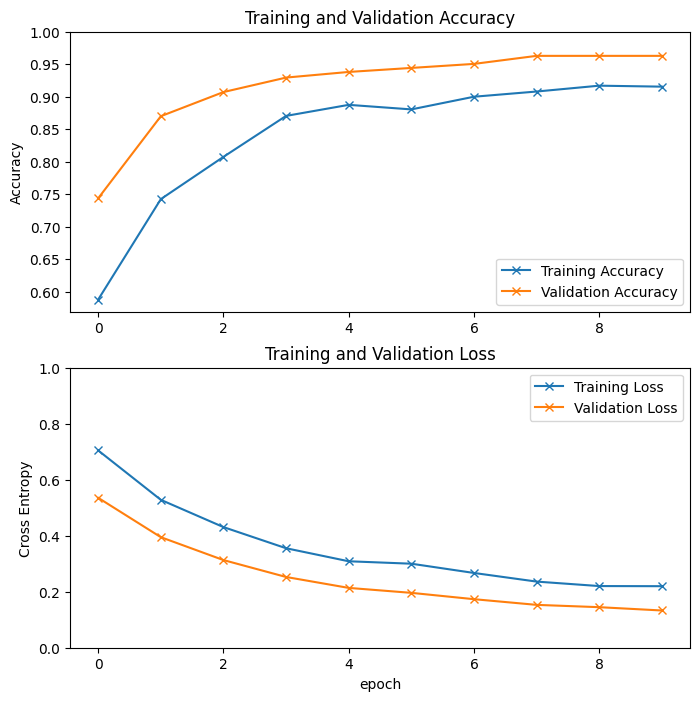

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='x')
plt.plot(val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='x')
plt.plot(val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 89ms/step - loss: 0.1073 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


Predictions:
 [1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1]
Labels:
 [1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1]


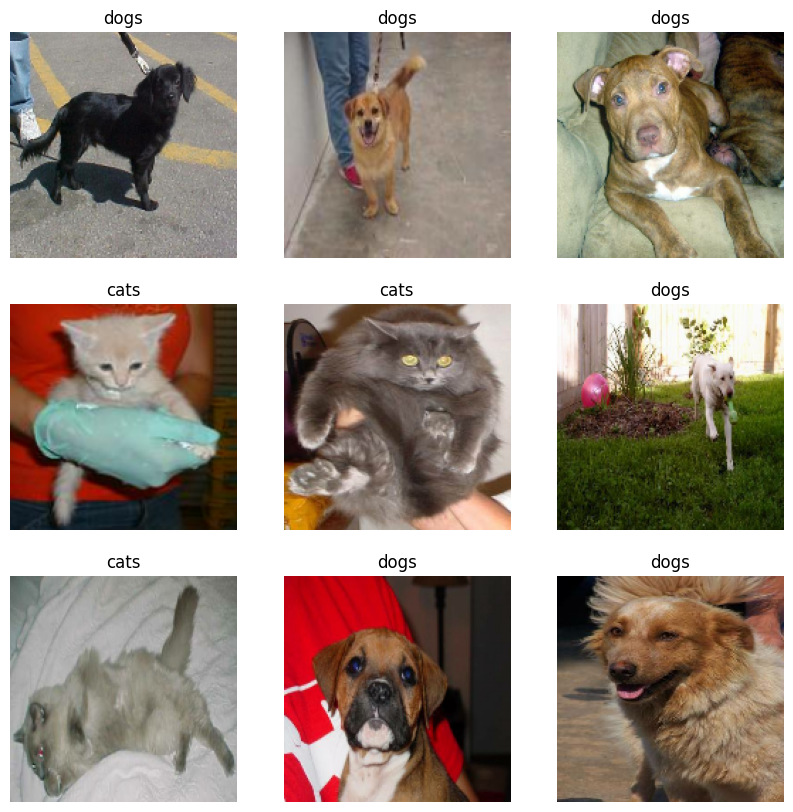

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [32]:
model.save("cat_dog_mobile_net_classifier.keras")

In [32]:
!pip install ultralytics